# Multi-Scale Spiking Network Model of Human Cerebral Cortex

**Model overview**: The model comprises all 34 areas of the Desikan-Killiany parcellation in one hemisphere of human cerebral cortex. Each area is modeled by a column with $\mathrm{1\mathrm{mm^{2}}}$ cortical surface. Within each column, the full number of neurons and synapses based on anatomical data is included. In total, this leads to 3.47 million neurons and 42.8 billion synapses. Both the intrinsic and the cortico-cortical connectivity are layer- and population-specific.

<img src="./figures/model_overview.png" alt="Model overview" width="1000"/>

# Down-scaled human multi-area model

This code in this notebook implements the down-scaled version of the multi-scale, spiking network model of human cortex developed at the Institute of Advanced Simulation (IAS-6), Research Center Jülich. The model has been documented in the following publication:

- [1] Pronold, J., Meegen, A. van, Shimoura, R. O., Vollenbröker, H., Senden, M., Hilgetag, C. C., Bakker, R., & Albada, S. J. (2024). Multi-scale spiking network model of human cerebral cortex. Cerebral Cortex. [https://doi.org/10.1093/cercor/bhae409](https://doi.org/10.1093/cercor/bhae409).

## Notebook Outline <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Parameterization](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
* [S2. Model Configuration, Instantiation and Simulation](#section_2)
    * [2.1. Configuring model parameters](#section_2_1)
    * [2.2. Instantiate a multi-area model](#section_2_2)
    * [2.3. Predict firing rates from theory](#section_2_3)
    * [2.4. Extract and visualize inter-areal connectivity](#section_2_3)
    * [2.5. Run a simulation](#section_2_5)
* [S3. Visualization of Network Dynamics](#section_3) 
    * [3.1. Mean firing rate over simulated populations](#section_3_1)
    * [3.2. Instantaneous firing rate over simulated areas](#section_3_2)
    * [3.3. Time-averaged firing rate over all populations](#section_3_3)
    * [3.4. Network dynamics](#section_3_4)
    * [3.5. Functional connectivity](#section_3_5)
* [Additional Notes](#section_4)

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
import os
import sys
import importlib.util

# Add the source directory to the system path
sys.path.append('./src/')

# Local application imports
from helpers.snakemake import nested_dict_update, get_git_revision_hash
from default_net_params import params as net_params
from data_preprocessing.cytoarchitecture import NeuronNumbers
from data_preprocessing.connectivity import SynapseNumbers
from network import Network, networkDictFromDump
from default_sim_params import params as sim_params
from simulation import Simulation
from simulation import simulationDictFromDump
from analysis import Analysis
from default_ana_params import params as ana_params

# Configure Matplotlib to render plots inline
%matplotlib inline

[INFO] [2024.10.28 17:54:56 /home/conda/feedstock_root/build_artifacts/nest-simulator_1636957195130/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2024.10.28 17:54:56 /home/conda/feedstock_root/build_artifacts/nest-simulator_1636957195130/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Nov 15 2021 06:23:02

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Go back to [Notebook Outline](#toc)

## S1. Parameterization <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

The values assigned for the following parameters are kept the same as in the paper except for the `scaling_factor` which is set as 0.005 enabling to simulate a down-scaled multi-area model with 2GB RAM. By default, it is set to 1.0 for simulating the full-scale model.

In [2]:
# Set scaling parameters
# value range/options: (0, 1.], change it to 1. to simulate the full-scale network
scaling_factor = 0.005

# Scaling factor for cortico-cortical connections (Chi) to excitatory neurons.
# Chi = 0.0 removes long-range cortico-cortical connections.
# Chi = 1.0 produces base version results in Pronold et al. (2024).
# Chi = 2.5 produces best fit version results in Pronold et al. (2024).
# obs: Chi to inhibitory neurons is set to 2.0 times the scaling factor for excitatory neurons.
net_params['cc_scalingEtoE'] = 1.0

Go back to [Notebook Outline](#toc)

## S2. Model Configuration, Instantiation and Simulation <a class="anchor" id="section_2"></a>

### 2.1. Configuring model parameters <a class="anchor" id="section_2_1"></a>

We try our best not to confuse users with too many parameters. So, the few parameters tunned will be automatically assigned in this section to properly run the simulation. 

However, if you want to explore the model, you can alter other parameters related to the network or simulation configuration by passing them in the `net_params` and `sim_params` dictionaries below. If this is not the case, you can execute the cell the way it is.

In [3]:
# Get path to the output directory
outpath = net_params['outpath']

# Get base path
base_path = os.getcwd()

# Set the scaling factor for the number of neurons and synapses
net_params['N_scaling'] = scaling_factor
net_params['K_scaling'] = scaling_factor

# Mean fullscale firing rate to scale the firing rates of the neurons
net_params['fullscale_rates'] = './simulated_data/base_theory_rates.pkl'

# Scaling factor for cortico-cortical connections (Chi) to inhibitory neurons.
# it is set to 2.0 times the scaling factor for excitatory neurons.
# This keeps the stability of the network.
net_params['cc_scalingEtoI'] = net_params['cc_scalingEtoE']*2.0

# Set simulation parameters
sim_params['t_sim'] = 2000.0        # Simulation time in ms
sim_params['master_seed'] = 2903    # Seed for the random number generator
num_threads = int(4)                # Number of threads to use for the simulation 

# Set plotting parameters
ana_params['plotRasterArea']['low'] = 1600      # Lower bound of the area to plot the raster plot
ana_params['plotRasterArea']['high'] = 2000     # Upper bound of the area to plot the raster plot
ana_params['plotRasterArea']['fraction'] = 0.5  # Fraction of neurons to plot in the raster plot

Go back to [Notebook Outline](#toc)

### 2.2. Generate connectivity matrix and define neuron numbers <a class="anchor" id="section_2_2"></a>

In this section, we generate the connectivity matrix and define the neuron numbers for the down-scaled multi-area model of the human cerebral cortex. The `NeuronNumbers` class is used to calculate the number of neurons in the network based on the provided surface area and cytoarchitecture parameters. Similarly, the `SynapseNumbers` class calculates the number of synapses in the network using the neuron numbers and predictive connectomic parameters.

The `Network` class is then instantiated with the neuron and synapse numbers, and the network configuration is saved to the output directory. The network hash is also generated for further reference.


In [4]:
# Create NeuroNumbers class
# This class calculates the number of neurons in the network
NN = NeuronNumbers(
    surface_area=net_params['surface_area'],
    **net_params['cytoarchitecture_params']
)
# Create SynapseNumbers class
# This class calculates the number of synapses in the network
SN = SynapseNumbers(
    NN=NN,
    **net_params['predictive_connectomic_params']
)

# Create Network
# This class creates the network
humam = Network(NN, SN, net_params)
# Extract the network dictionary
humam.dump(outpath)
# Get the network hash for further reference
net_hash = humam.getHash()

Dropping layer IV in caudalmiddlefrontal because it contains 3375 < 5000 neurons.
Dropping layer IV in lateraloccipital because it contains 3000 < 5000 neurons.
Dropping layer VI in parahippocampal because it contains 3200 < 5000 neurons.
Dropping layer IV in parsorbitalis because it contains 625 < 5000 neurons.


### 2.3. Predict firing rates from theory <a class="anchor" id="section_2_3"></a>

Note: the prediction may differ from the simulation results, especially in the presence of synchrony.

In [5]:
# p, r = M.theory.integrate_siegert()

# print("Mean-field theory predicts an average "
#       "firing rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Go back to [Notebook Outline](#toc)

### 2.4. Extract and visualize inter-areal connectivity <a class="anchor" id="section_2_4"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. 
- Neuron numbers of all populations in each area are stored in `humam.net['neuron_numbers']` as a multi-index Pandas Series. The index is hierarchically organized as Area, Layer, Population.

- Number of synapses can be accessed via `humam['synapses_internal']`.
  Number of synapses that target neurons (rows) receive from source neurons (columns), organized as a multi-index Pandas DataFrame. The index is hierarchically organized as Area, Layer, Population.

The figure below shows the inter-areal connectivity of the model expressed as the relative indegrees of each target area. The relative indegree of a target area from a specific source area is calculated by dividing its indegree by the sum of indegrees that the target area receives from all sources.

Comparable figure in our publications: <br>
1. Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ <br>
   Multi-scale account of the network structure of macaque visual cortex
   Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4) <br>
   **Fig. 4D Area-level connectivity of the model, based on data in a–c, expressed as relative indegrees for each target area.**

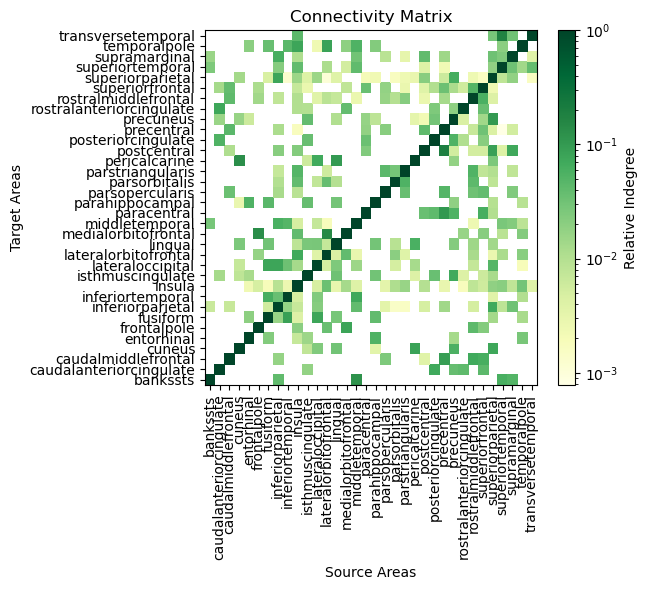

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Calculate the indegrees
indegrees = humam.net['synapses_internal'].div(humam.net['neuron_numbers'], axis=0)

# Group the subpopulations together by summing the indegrees for each area
grouped_indegrees = indegrees.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()

# Normalize the relative indegrees by dividing each indegree by the maximum value for the target area
relative_indegrees = grouped_indegrees.div(grouped_indegrees.max(axis=1), axis=0)

# Plot the relative interarea connectivity matrix using pcolor
plt.figure(figsize=(6.5, 6.0))
plt.pcolor(relative_indegrees, cmap='YlGn', norm=LogNorm())
plt.colorbar(label='Relative Indegree')
plt.title('Connectivity Matrix')
plt.xlabel('Source Areas')
plt.ylabel('Target Areas')
plt.xticks(ticks=np.arange(0.5, len(relative_indegrees.columns), 1), labels=relative_indegrees.columns, rotation=90)
plt.yticks(ticks=np.arange(0.5, len(relative_indegrees.index), 1), labels=relative_indegrees.index)
plt.tight_layout()
plt.show()


Go back to [Notebook Outline](#toc)

### 2.5. Run a simulation <a class="anchor" id="section_2_5"></a>

Run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.

In [8]:
# Read network dict
net_folder = os.path.join(outpath, net_hash)
net_dict = networkDictFromDump(net_folder)

# Create Simulation class
sim = Simulation(sim_params, net_dict)
# Extract the simulation dictionary
sim.dump(net_folder)
# Get the simulation hash
sim_hash = sim.getHash()

# Set output directory according to hashes
# and run the simulation
data_path = os.path.join(outpath, net_hash, sim_hash)
sim.setup(data_path, num_threads)
sim.simulate()

/home/shimoura/Documents/GitHub/humam-add-downscaling-factor/./src/network.py:892: YAMLLoadWarning:calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/home/shimoura/Documents/GitHub/humam-add-downscaling-factor/./src/network.py:897: YAMLLoadWarning:calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/home/shimoura/Documents/GitHub/humam-add-downscaling-factor/./src/network.py:902: YAMLLoadWarning:calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/home/shimoura/Documents/GitHub/humam-add-downscaling-factor/./src/network.py:907: YAMLLoadWarning:calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/home/shimoura/miniconda

data directory already exists
Data will be written to /home/shimoura/Documents/GitHub/humam-add-downscaling-factor/out/5c92d51068c956a81d67d16610aa9dcc/e6f6894f7ce545b48d43876532c39947
Master seed: 2903 
Number of total processes: 4
Seeds for random number generators of virtual processes: [2908, 2909, 2910, 2911]
Global random number generator seed: 2907

Oct 28 18:01:52 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Oct 28 18:01:52 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Oct 28 18:01:52 Network::create_rngs_ [Info]: 
    Creating default RNGs

Oct 28 18:01:52 Network::create_grng_ [Info]: 
    Creating new default global RNG

Oct 28 18:01:52 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Oct 28 18:01:52 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Oct 28 18:01:52 Network::create_rngs_ [Info]: 
    Creating default RNGs

Oct 28 18:01:5

**Reminder**: The spike trains of simulated results are saved to the folder with path `./out/<net_hash>/<sim_hash>/spikes/`, where `<net_hash>` and `<sim_hash>` are generated in 2.2 and in this section respectively. All statistics describing network dynamics are computed from the saved spike trains.

Go back to [Notebook Outline](#toc)

## S3. Visualization of Network Dynamics <a class="anchor" id="section_3"></a>

**Important**: `cc_weights_factor` plays a crucial role in transitioning the network activity from the base to the best-fit version.  In the full-scale network, the base and best-fit versions activities are achieved when this parameter is set to `1.0` and `2.5`, respectively.

In [9]:
# Read simulation dict
sim_folder = os.path.join(outpath, net_hash, sim_hash)
sim_dict = simulationDictFromDump(sim_folder)

# Create Analysis class and export it
ana = Analysis(ana_params, net_dict, sim_dict, sim_folder, base_path)
ana.dump(sim_folder)

# Run the full analysis
# ana.fullAnalysis()

Results will be written to /home/shimoura/Documents/GitHub/humam-add-downscaling-factor/out/5c92d51068c956a81d67d16610aa9dcc/e6f6894f7ce545b48d43876532c39947/1e8227c314be5ff76f515e7dd9f17baa/plots
Plots will be written to /home/shimoura/Documents/GitHub/humam-add-downscaling-factor/out/5c92d51068c956a81d67d16610aa9dcc/e6f6894f7ce545b48d43876532c39947/1e8227c314be5ff76f515e7dd9f17baa/plots
18:05:10.726974 Reading popGids
_readPopGids took 0.008 s
18:05:10.735449 Reading spikes
_readSpikes took 0.148 s


/home/shimoura/Documents/GitHub/humam-add-downscaling-factor/./src/simulation.py:553: YAMLLoadWarning:calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


### 3.1. Mean firing rate over simulated populations <a class="anchor" id="section_3_1"></a>

In [10]:
# Print the mean firing rate over simulated populations
mean_rates_per_pop = ana.meanFiringRate()
print("Average firing rate: {:.2f} spikes/s".format(mean_rates_per_pop.mean()))

meanFiringRate took 0.003 s
Average firing rate: 56.30 spikes/s


### 3.2. Instantaneous firing rate over simulated areas <a class="anchor" id="section_3_2"></a>

In [11]:
rate_hist, rate_hist_areas = ana.firingRateHistogram()

firingRateHistogram took 0.021 s


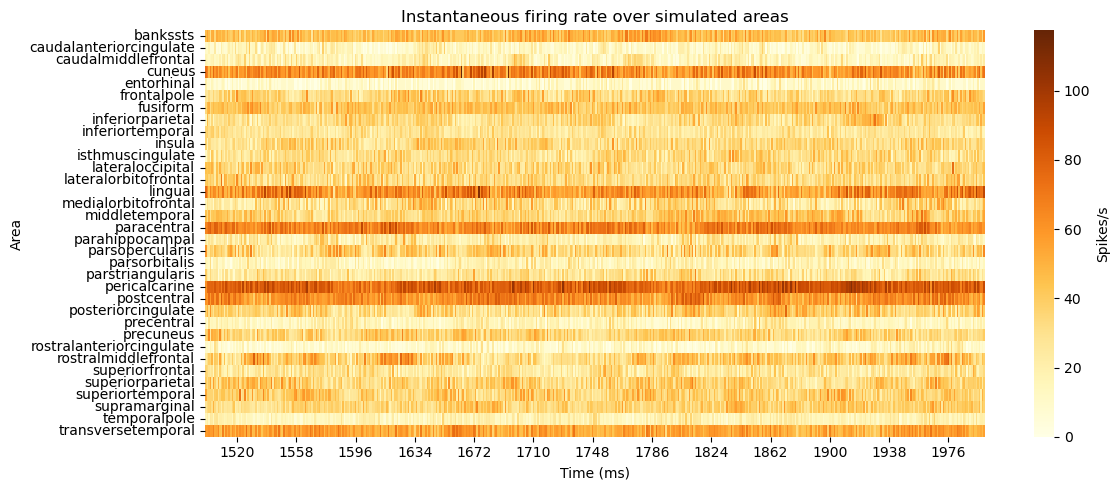

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert rate_hist_areas to a DataFrame for easier plotting
rate_hist_areas *= 1000  # Convert to spikes/s
rate_hist_areas_df = pd.DataFrame(rate_hist_areas.tolist(), index=rate_hist_areas.index)

# Plot the heatmap with an orange-yellow color palette
plt.figure(figsize=(12, 5))
sns.heatmap(rate_hist_areas_df, cmap='YlOrBr', cbar_kws={'label': 'Spikes/s'}, yticklabels=rate_hist_areas_df.index)
plt.xlabel('Time (ms)')
plt.ylabel('Area')
plt.title('Instantaneous firing rate over simulated areas')
plt.xticks(rotation=0)  # Rotate x-axis labels to make the times horizontal
plt.xlim(sim_params['t_sim']-500, sim_params['t_sim'])
plt.tight_layout()
plt.show()


### 3.3. Time-averaged firing rate over simulated populations <a class="anchor" id="section_3_3"></a>

An overview of time-averaged firing rate over simulated populations encoded in colors with areas along x-axis and populations along y-axis. Layers that are not present in the model for specific areas are represented by the "X" mark.

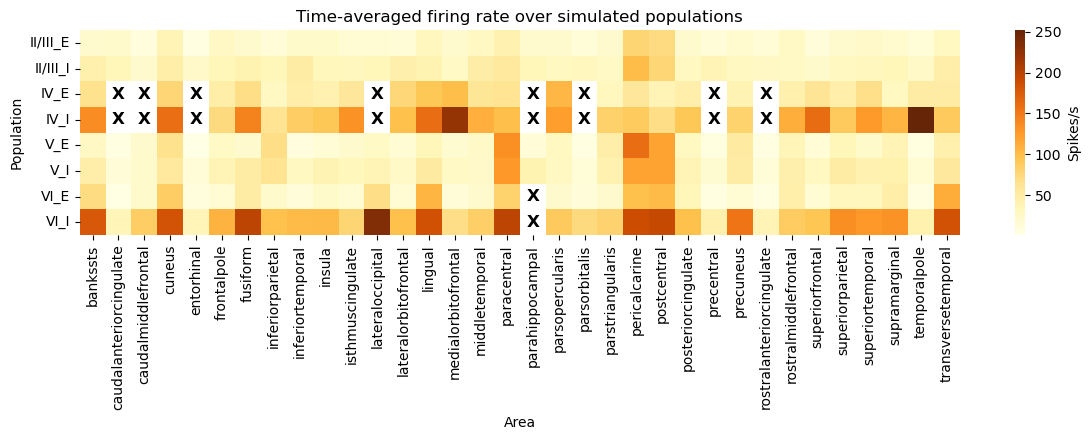

In [13]:
import matplotlib.pyplot as plt

# Pivot the DataFrame to have areas on the x-axis and layer+pop on the y-axis
mean_rates_df = mean_rates_per_pop.reset_index().pivot(index=['layer', 'pop'], columns='area', values=0)

# Create a new index combining layer and pop
mean_rates_df.index = mean_rates_df.index.map(lambda x: f"{x[0]}_{x[1]}")

# Create a mask for NaN values
mask = mean_rates_df.isna()

# Plot the heatmap with external grid
plt.figure(figsize=(12, 4.5))
sns.heatmap(mean_rates_df, cmap='YlOrBr', fmt=".2f", mask=mask, cbar_kws={'label': 'Spikes/s'})
plt.title('Time-averaged firing rate over simulated populations')
plt.xlabel('Area')
plt.ylabel('Population')

# Rotate x-tick and y-tick labels
plt.yticks(rotation=0)

# Plot X marks for NaN values
for i in range(mean_rates_df.shape[0]):
    for j in range(mean_rates_df.shape[1]):
        if mask.iloc[i, j]:
            plt.text(j + 0.5, i + 0.5, 'X', ha='center', va='center', color='black', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

### 3.4. Network dynamics <a class="anchor" id="section_3_4"></a>

Comparable figures in our publications: <br>
1. Schmidt M, Bakker R, Shen K, Bezgin B, Diesmann M & van Albada SJ (2018)
   A multi-scale layer-resolved spiking network model of
   resting-state dynamics in macaque cortex. PLOS Computational Biology, 14(9): e1006359. [https://doi.org/10.1371/journal.pcbi.1006359](https://doi.org/10.1371/journal.pcbi.1006359) <br>
   **Fig 3.  Ground state of the model.** <br>
   **Fig 5.  Resting state of the model with χ = 1.9 (metastable state).**

In [14]:
for area in humam.net['area_list']:
    ana.plotRasterArea(area)

### 3.5. Functional connectivity <a class="anchor" id="section_3_5"></a>

Comparison of area-level functional connectivity (FC) between the down-scaled HuMAM and human experimental data. (A) Simulated FC measured by the zero-time-lag correlation coefficient of synaptic input currents. (B) FC of human resting-state fMRI (see Materials and methods).

In [15]:
#TODO

Go back to [Notebook Outline](#toc)

## Additional Notes <a class="anchor" id="section_4"></a>

1. Simulation data <br>
The spike data of all simulated populations for all simulations are saved, by default, in `./out/<network_hash>/<simulation_hash>/spikes` where `<simulation_hash>` can be accessed in the output of 2.2. Or users can see their latest simulation by checking the column "Last Modified" and find the folder with the latest change.
2. Statistics <br>
The statistics of network dynamics computed from the spike trains can be found in `./out/<network_hash>/<simulation_hash>/<analysis_hash>`. You may calculate more statistics from the functions defined in `./src/analysis.py` to explore more about network dynamics.

Go back to [Notebook Outline](#toc)